# GAN
## 目录
* autoencoder
* vae
* gan

source: https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch

# 自动编码器
自动编码器最开始是作为一种数据压缩方法，同时还可以在卷积网络中进行逐层预训练，但是随后更多结构复杂的网络，比如 resnet 的出现使得我们能够训练任意深度的网络，自动编码器就不再使用在这个方面，下面我们讲一讲自动编码器的一个新的应用，这是随着生成对抗模型而出现的，就是使用自动编码器生成数据。

自动编码器的一般结构如下

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzr05igw3j30ni06j3z4.jpg)

由上面的图片，我们能够看到，第一部分是编码器(encoder)，第二部分是解码器(decoder)，编码器和解码器都可以是任意的模型，通常我们可以使用神经网络作为我们的编码器和解码器，输入的数据经过神经网络降维到一个编码，然后又通过另外一个神经网络解码得到一个与原始数据一模一样的生成数据，通过比较原始数据和生成数据，希望他们尽可能接近，所以最小化他们之间的差异来训练网络中编码器和解码器的参数。

当训练完成之后，我们如何生成数据呢？非常简单，我们只需要拿出解码器的部分，然后随机传入 code，就可以通过解码器生成各种各样的数据

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmzrx3d3ygj30nu06ijs2.jpg)

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
# 简单的自编码解码器
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3) # 输出的 code 是 3 维，便于可视化
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

##使用卷积网络
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # (b, 16, 10, 10)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 5, 5)
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # (b, 8, 3, 3)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (b, 8, 2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # (b, 16, 5, 5)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # (b, 8, 15, 15)
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # (b, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [6]:
#简单训练
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image
from torch.utils.data import DataLoader

im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 标准化
])

train_set = MNIST('/home/zlj/data/mnist', transform=im_tfs)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)

#测试输出
#net = autoencoder()

conv_net = conv_autoencoder() #带卷积网络
if torch.cuda.is_available():
    conv_net = conv_net.cuda()

x = Variable(torch.randn(1, 28*28)) # batch size 是 1
code, _ = conv_net(x)
print(code.shape)

#定义损失函数和优化器
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam(conv_net.parameters(), lr=1e-3, weight_decay=1e-5)

def to_img(x):
    '''
    定义一个函数将最后的结果转换回图片
    '''
    x = 0.5 * (x + 1.)
    x = x.clamp(0, 1)
    x = x.view(x.shape[0], 1, 28, 28)
    return x

torch.Size([1, 3])


In [9]:
import time
import os
# 开始训练自动编码器
since = time.time()
for e in range(100):
    for im, _ in train_data:
        im = im.view(im.shape[0], -1)
        im = Variable(im)
        # 前向传播
        _, output = conv_net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e + 1, loss.data[0]))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/image_{}.png'.format(e + 1))
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

epoch: 20, Loss: 91.2643
epoch: 40, Loss: 99.6230
epoch: 60, Loss: 98.5777
epoch: 80, Loss: 96.4058
epoch: 100, Loss: 86.1791
Training complete in 20m 14s


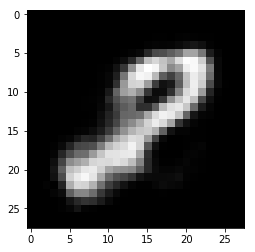

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
#随机给定一个code，看输出图像
code = Variable(torch.FloatTensor([[1.19, -3.36, 2.06]])) # 给一个 code 是 (1.19, -3.36, 2.06)
decode = net.decoder(code)
decode_img = to_img(decode).squeeze()
decode_img = decode_img.data.numpy() * 255
plt.imshow(decode_img.astype('uint8'), cmap='gray') # 生成图片 3

# 变分自动编码器
变分编码器是自动编码器的升级版本，其结构跟自动编码器是类似的，也由编码器和解码器构成。

回忆一下，自动编码器有个问题，就是并不能任意生成图片，因为我们没有办法自己去构造隐藏向量，需要通过一张图片输入编码我们才知道得到的隐含向量是什么，这时我们就可以通过变分自动编码器来解决这个问题。

其实原理特别简单，只需要在编码过程给它增加一些限制，迫使其生成的隐含向量能够粗略的遵循一个标准正态分布，这就是其与一般的自动编码器最大的不同。

这样我们生成一张新图片就很简单了，我们只需要给它一个标准正态分布的随机隐含向量，这样通过解码器就能够生成我们想要的图片，而不需要给它一张原始图片先编码。

一般来讲，我们通过 encoder 得到的隐含向量并不是一个标准的正态分布，为了衡量两种分布的相似程度，我们使用 KL divergence，利用其来表示隐含向量与标准正态分布之间差异的 loss，另外一个 loss 仍然使用生成图片与原图片的均方误差来表示。

KL divergence 的公式如下

$$
D{KL} (P || Q) =  \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} dx
$$
## 重参数
为了避免计算 KL divergence 中的积分，我们使用重参数的技巧，不是每次产生一个隐含向量，而是生成两个向量，一个表示均值，一个表示标准差，这里我们默认编码之后的隐含向量服从一个正态分布的之后，就可以用一个标准正态分布先乘上标准差再加上均值来合成这个正态分布，最后 loss 就是希望这个生成的正态分布能够符合一个标准正态分布，也就是希望均值为 0，方差为 1

所以标准的变分自动编码器如下

![](https://ws4.sinaimg.cn/large/006tKfTcgy1fn15cq6n7pj30k007t0sv.jpg)
所以最后我们可以将我们的 loss 定义为下面的函数，由均方误差和 KL divergence 求和得到一个总的 loss

```
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD
```

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        return self.decode(z), mu, logvar # 解码，同时输出均值方差

net = VAE() # 实例化网络
if torch.cuda.is_available():
    net = net.cuda()

reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# 生成对抗网络
前面我们讲了自动编码器和变分自动编码器，不管是哪一个，都是通过计算生成图像和输入图像在**每个像素点**的误差来生成 loss，这一点是特别不好的，因为不同的像素点可能造成不同的视觉结果，但是可能他们的 loss 是相同的，所以通过单个像素点来得到 loss 是不准确的，这个时候我们需要一种全新的 loss 定义方式，就是通过对抗进行学习。

## GANs
这种训练方式定义了一种全新的网络结构，就是生成对抗网络，也就是 GANs。这一部分，我们会形象地介绍生成对抗网络，以及用代码进行实现，而在书中会更加详细地介绍 GANs 的数学推导。

根据这个名字就可以知道这个网络是由两部分组成的，第一部分是生成，第二部分是对抗。简单来说，就是有一个生成网络和一个判别网络，通过训练让两个网络相互竞争，生成网络来生成假的数据，对抗网络通过判别器去判别真伪，最后希望生成器生成的数据能够以假乱真。

可以用这个图来简单的看一看这两个过程

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22oma081j30k007cgll.jpg)

### Discriminator Network
首先我们来讲一下对抗过程，因为这个过程更加简单。

对抗过程简单来说就是一个判断真假的判别器，相当于一个二分类问题，我们输入一张真的图片希望判别器输出的结果是1，输入一张假的图片希望判别器输出的结果是0。这其实已经和原图片的 label 没有关系了，不管原图片到底是一个多少类别的图片，他们都统一称为真的图片，label 是 1 表示真实的；而生成的假的图片的 label 是 0 表示假的。

我们训练的过程就是希望这个判别器能够正确的判出真的图片和假的图片，这其实就是一个简单的二分类问题，对于这个问题可以用我们前面讲过的很多方法去处理，比如 logistic 回归，深层网络，卷积神经网络，循环神经网络都可以。

### Generator Network
接着我们看看生成网络如何生成一张假的图片。首先给出一个简单的高维的正态分布的噪声向量，如上图所示的 D-dimensional noise vector，这个时候我们可以通过仿射变换，也就是 xw+b 将其映射到一个更高的维度，然后将他重新排列成一个矩形，这样看着更像一张图片，接着进行一些卷积、转置卷积、池化、激活函数等进行处理，最后得到了一个与我们输入图片大小一模一样的噪音矩阵，这就是我们所说的假的图片。

这个时候我们如何去训练这个生成器呢？这就需要通过对抗学习，增大判别器判别这个结果为真的概率，通过这个步骤不断调整生成器的参数，希望生成的图片越来越像真的，而在这一步中我们不会更新判别器的参数，因为如果判别器不断被优化，可能生成器无论生成什么样的图片都无法骗过判别器。

生成器的效果可以看看下面的图示

![](https://ws3.sinaimg.cn/large/006tNc79gy1fn22s47jnfj30k005c74b.jpg)

关于生成对抗网络，出现了很多变形，比如 WGAN，LS-GAN 等等，这一节我们只使用 mnist 举一些简单的例子来说明，更复杂的网络结构可以再 github 上找到相应的实现

## GAN实现

In [13]:
import torch
from torch import nn
from torch.autograd import Variable

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0

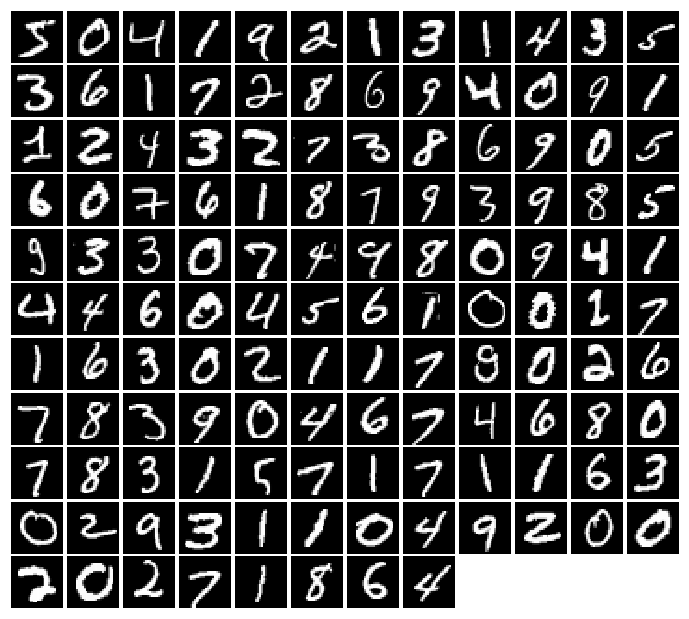

In [14]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('/home/zlj/data/mnist', train=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('/home/zlj/data/mnist', train=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)

## 简单版本的生成对抗网络
通过前面我们知道生成对抗网络有两个部分构成，一个是生成网络，一个是对抗网络，我们首先写一个简单版本的网络结构，生成网络和对抗网络都是简单的多层神经网络

### 判别网络
判别网络的结构非常简单，就是一个二分类器，结构如下:
* 全连接(784 -> 256)
* leakyrelu,  $\alpha$ 是 0.2
* 全连接(256 -> 256)
* leakyrelu, $\alpha$ 是 0.2
* 全连接(256 -> 1)

其中 leakyrelu 是指 f(x) = max($\alpha$ x, x)

In [15]:
def discriminator():
    net = nn.Sequential(        
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    return net

### 生成网络
接下来我们看看生成网络，生成网络的结构也很简单，就是根据一个随机噪声生成一个和数据维度一样的张量，结构如下：
* 全连接(噪音维度 -> 1024)
* relu
* 全连接(1024 -> 1024)
* relu
* 全连接(1024 -> 784)
* tanh 将数据裁剪到 -1 ~ 1 之间

In [16]:
def generator(noise_dim=NOISE_DIM):   
    net = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    return net

接下来我们需要定义生成对抗网络的 loss，通过前面的讲解我们知道，对于对抗网络，相当于二分类问题，将真的判别为真的，假的判别为假的，作为辅助，可以参考一下论文中公式

$$ \ell_D = \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

而对于生成网络，需要去骗过对抗网络，也就是将假的也判断为真的，作为辅助，可以参考一下论文中公式

$$\ell_G  =  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

如果你还记得前面的二分类 loss，那么你就会发现上面这两个公式就是二分类 loss

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$
如果我们把 D(x) 看成真实数据的分类得分，那么 D(G(z)) 就是假数据的分类得分，所以上面判别器的 loss 就是将真实数据的得分判断为 1，假的数据的得分判断为 0，而生成器的 loss 就是将假的数据判断为 1

下面我们来实现一下

In [17]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss
def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

In [18]:
def train_a_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).view(bs, -1).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data[0], g_error.data[0]))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.342, G:0.6885


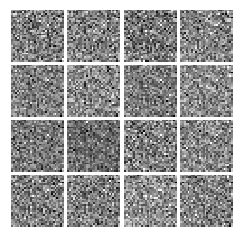

()
Iter: 250, D: 1.352, G:0.909


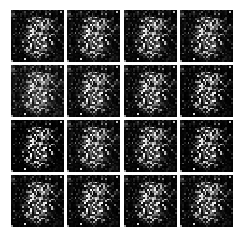

()
Iter: 500, D: 1.23, G:1.037


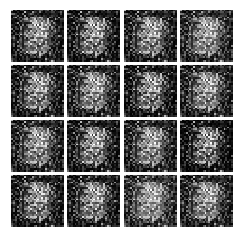

()
Iter: 750, D: 1.67, G:0.4344


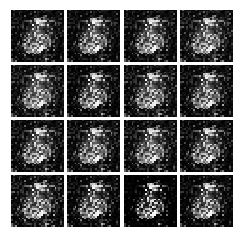

()
Iter: 1000, D: 0.9393, G:1.322


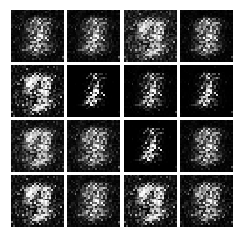

()
Iter: 1250, D: 0.744, G:1.725


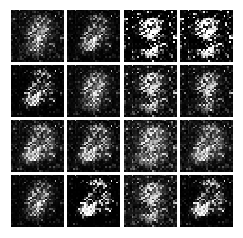

()
Iter: 1500, D: 0.7343, G:1.78


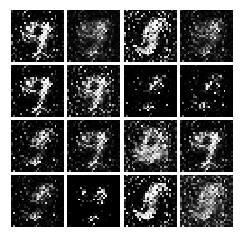

()
Iter: 1750, D: 0.8716, G:1.506


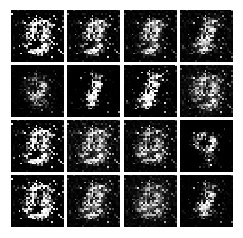

()
Iter: 2000, D: 1.104, G:0.88


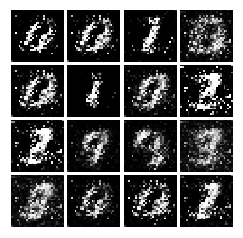

()
Iter: 2250, D: 1.122, G:0.7994


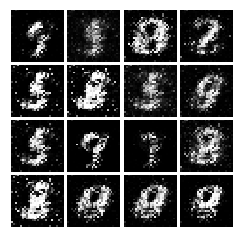

()
Iter: 2500, D: 1.029, G:1.871


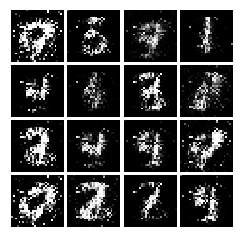

()
Iter: 2750, D: 1.105, G:1.427


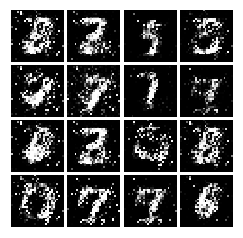

()
Iter: 3000, D: 1.014, G:1.814


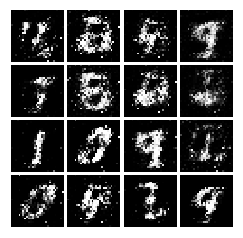

()
Iter: 3250, D: 1.319, G:1.704


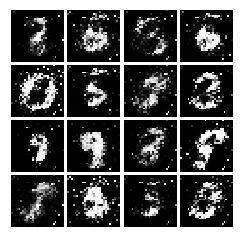

()
Iter: 3500, D: 0.9372, G:1.858


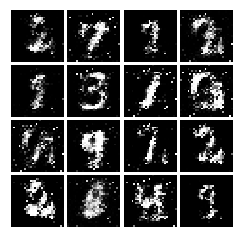

()
Iter: 3750, D: 1.191, G:0.7696


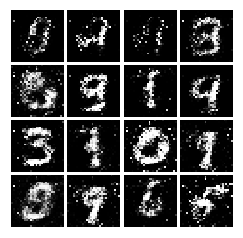

()


In [19]:
D = discriminator().cuda()
G = generator().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, discriminator_loss, generator_loss)

我们已经完成了一个简单的生成对抗网络，是不是非常容易呢。但是可以看到效果并不是特别好，生成的数字也不是特别完整，因为我们仅仅使用了简单的多层全连接网络。

除了这种最基本的生成对抗网络之外，还有很多生成对抗网络的变式，有结构上的变式，也有 loss 上的变式，我们先讲一讲其中一种在 loss 上的变式，Least Squares GAN

## Least Squares GAN
[Least Squares GAN](https://arxiv.org/abs/1611.04076) 比最原始的 GANs 的 loss 更加稳定，通过名字我们也能够看出这种 GAN 是通过最小平方误差来进行估计，而不是通过二分类的损失函数，下面我们看看 loss 的计算公式

$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [20]:
def ls_discriminator_loss(scores_real, scores_fake):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake ** 2).mean()
    return loss

def ls_generator_loss(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()
    return loss

Iter: 0, D: 0.5468, G:0.4549


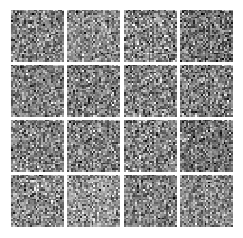

()
Iter: 250, D: 0.09249, G:0.2903


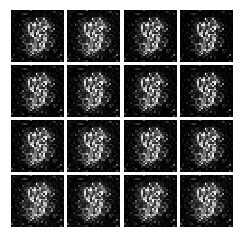

()
Iter: 500, D: 0.1332, G:0.2978


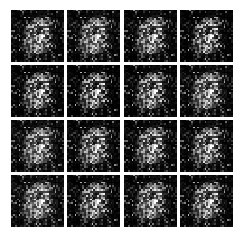

()
Iter: 750, D: 0.07965, G:0.3819


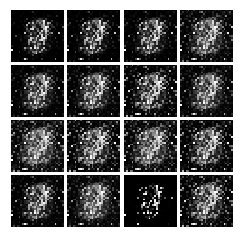

()
Iter: 1000, D: 0.05518, G:0.5742


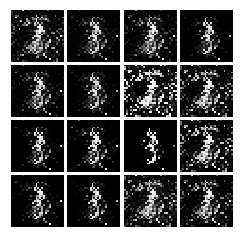

()
Iter: 1250, D: 0.0495, G:0.4328


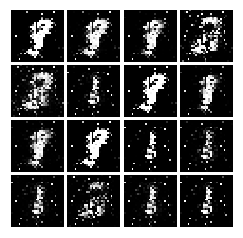

()
Iter: 1500, D: 0.06294, G:0.5457


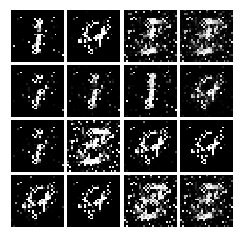

()
Iter: 1750, D: 0.03935, G:0.4423


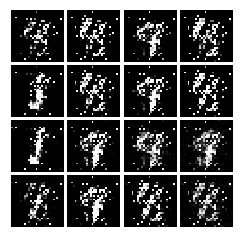

()
Iter: 2000, D: 0.06854, G:0.3897


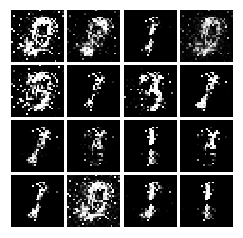

()
Iter: 2250, D: 0.214, G:0.1711


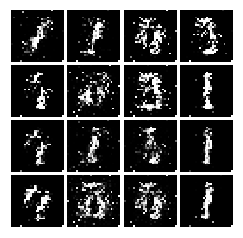

()
Iter: 2500, D: 0.07745, G:0.3505


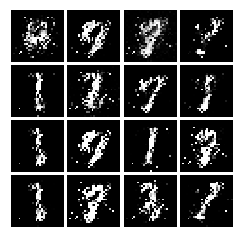

()
Iter: 2750, D: 0.09507, G:0.3149


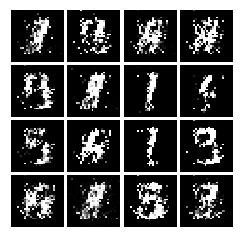

()
Iter: 3000, D: 0.08135, G:0.3775


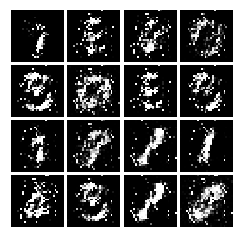

()
Iter: 3250, D: 0.1644, G:0.4301


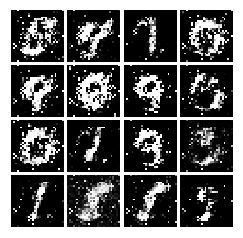

()
Iter: 3500, D: 0.1227, G:0.3623


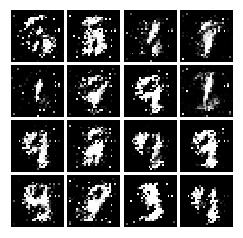

()
Iter: 3750, D: 0.1249, G:0.2659


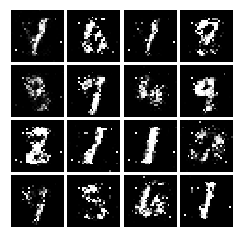

()


In [21]:
D = discriminator().cuda()
G = generator().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, ls_discriminator_loss, ls_generator_loss)

## Deep Convolutional GANs
深度卷积生成对抗网络特别简单，就是将生成网络和对抗网络都改成了卷积网络的形式，下面我们来实现一下

### 卷积判别网络
卷积判别网络就是一个一般的卷积网络，结构如下

* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [22]:
class build_dc_classifier(nn.Module):
    def __init__(self):
        super(build_dc_classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

### 卷积生成网络
卷积生成网络需要将一个低维的噪声向量变成一个图片数据，结构如下

* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Reshape into Image Tensor
* 64 conv2d^T filters of 4x4, stride 2, padding 1, ReLU
* BatchNorm
* 1 conv2d^T filter of 4x4, stride 2, padding 1, TanH

In [23]:
class build_dc_generator(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(build_dc_generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x

In [24]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data[0], g_error.data[0]))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.329, G:0.6114


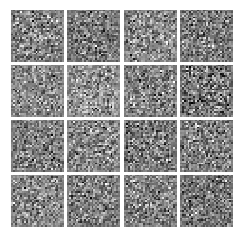

()
Iter: 250, D: 0.05262, G:7.107


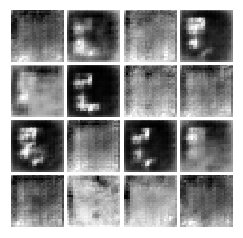

()
Iter: 500, D: 0.7506, G:1.085


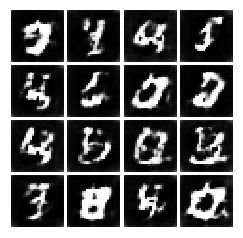

()
Iter: 750, D: 0.9343, G:1.354


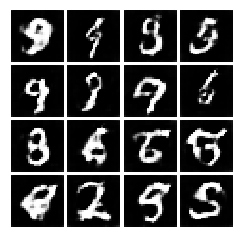

()
Iter: 1000, D: 1.074, G:1.014


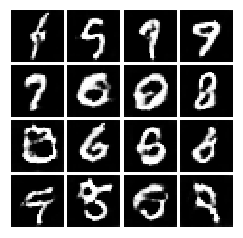

()
Iter: 1250, D: 1.055, G:1.482


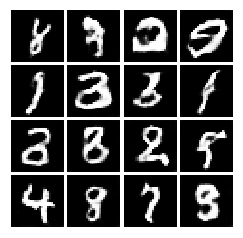

()
Iter: 1500, D: 1.079, G:1.103


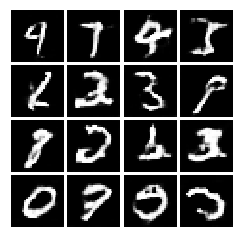

()
Iter: 1750, D: 1.109, G:1.077


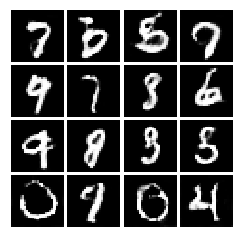

()


In [25]:
D_DC = build_dc_classifier().cuda()
G_DC = build_dc_generator().cuda()

D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)

train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=5)